In [1]:
%matplotlib inline

import openpyxl
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import *
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import json
import re

import statsmodels.api as sm
from patsy import dmatrices
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.base.model import LikelihoodModelResults
import seaborn as sns
import scipy.stats as stats

In [2]:
with open("geoBoundaries-RUS-ADM1_simplified.geojson", "r") as f:
    gbnd = json.load(f)

In [3]:
polygons = []

for f in gbnd["features"]:
    match f["geometry"]["type"]:
        case "Polygon":
            poly = f["geometry"]["coordinates"][0]
            polygons.append(Polygon(np.array(poly)))
        case "MultiPolygon":
            for ff in f["geometry"]["coordinates"]:
                poly = ff[0]
                polygons.append(Polygon(np.array(poly)))

In [6]:
with open("Синкретизм.xlsx", "rb") as f:
    mmr = io.BytesIO(f.read())

wb = openpyxl.load_workbook(mmr, read_only=True)

In [7]:
ws = wb["Координаты"]

In [8]:
coords_darl = np.array([list(map(float, cell.value.split(", "))) for row in ws["P2":"P43"] for cell in row])[:, ::-1]
coords_corpora = np.array([list(map(float, cell.value.split(", "))) for row in ws["H2":"H43"] for cell in row])[:, ::-1]

corpora = np.array([cell.value for row in ws["L2":"L43"] for cell in row])

values = np.array([[cell.value for cell in row] for row in ws["S2":"X43"]])

In [9]:
coords_darl = coords_darl[corpora != None]
coords_corpora = coords_corpora[corpora != None]
values = values[corpora != None]

corpora = corpora[corpora != None]

In [10]:
unique_corpora = list(set(corpora))
corpus_to_code = {corpus: i for i, corpus in enumerate(unique_corpora)}
codes = [corpus_to_code[corpus] for corpus in corpora]

In [11]:
labels = {}
for coord, corpus in zip(coords_corpora, corpora):
    if corpus not in labels:
        labels[corpus] = coord

# for corpus, coord in labels.items():
#     rand = (np.random.random(2) * 2 - 1) / 5
#     labels[corpus] = coord + rand
#     # ax.text(*coord, corpus, fontsize=3)

labels = list(labels.items())

In [12]:
def create_sector_marker(theta1, theta2):
    theta1, theta2 = np.deg2rad(theta1), np.deg2rad(theta2)
    n = 1000
    angles = np.linspace(theta1, theta2, n)
    
    vertices = [(0, 0)] + [(np.cos(a), np.sin(a)) for a in angles] + [(0, 0)]
    codes = [Path.MOVETO] + [Path.LINETO] * n + [Path.CLOSEPOLY]
    
    return Path(vertices, codes)

In [13]:
gen_path = create_sector_marker(-30, 90)

gen_u_path = create_sector_marker(50, 90)
gen_other_path = create_sector_marker(50, 10)
gen_without_path = create_sector_marker(10, -30)

dat_path = create_sector_marker(-150, -30)
loc_path = create_sector_marker(90, 210)

In [14]:
# with stress
gen_u_e = [1, 0, 0, 1, 0, 0, 0, 1]
gen_u_i = [0, 1, 0, 0, 1, 1, 1, 0]
gen_u_Ci = [0, 0, 1, 0, 0, 0, 0, 0]

gen_other_e = [0, 1, 1, 0, 1, 1, 0, 0]
gen_other_i = [1, 0, 0, 1, 0, 0, 1, 0]
gen_other_Ci = [0, 0, 1, 0, 0, 1, 0, 1]

gen_without_e = [0, 0, 0, 0, 0, 0, 0, 0]
gen_without_i = [1, 1, 1, 1, 1, 1, 1, 1]
gen_without_Ci = [0, 0, 0, 0, 0, 0, 0, 0]

dat_e = [1, 1, 0, 1, 0, 0, 1, 1]
dat_i = [0, 0, 1, 0, 1, 1, 0, 0]
dat_Ci = [0, 0, 1, 0, 0, 0, 0, 0]

loc_e = [1, 1, 0, 1, 0, 0, 0, 1]
loc_i = [0, 0, 1, 0, 1, 1, 1, 0]
loc_Ci = [0, 0, 1, 0, 0, 0, 0, 0]

In [15]:
gen_u_rgb = np.stack((gen_u_e, gen_u_i, gen_u_Ci)).T
gen_other_rgb = np.stack((gen_other_e, gen_other_i, gen_other_Ci)).T
gen_without_rgb = np.stack((gen_without_e, gen_without_i, gen_without_Ci)).T
dat_rgb = np.stack((dat_e, dat_i, dat_Ci)).T
loc_rgb = np.stack((loc_e, loc_i, loc_Ci)).T

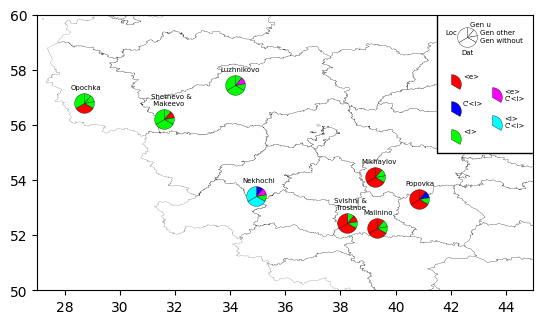

In [16]:
collection = PatchCollection(polygons, edgecolor='black', facecolor='none', linewidths=0.1)

fig, ax = plt.subplots()
ax.add_collection(collection)

# plt.scatter(*coords_corpora.T, c=codes, cmap='tab20', s=10)

size = 200
linewidth = 0.25
div_ = 1

for (corpus, coord), gen_u_rgb_, gen_other_rgb_, gen_without_rgb_, dat_rgb_, loc_rgb_ in zip(labels, gen_u_rgb, gen_other_rgb, gen_without_rgb, dat_rgb, loc_rgb):
    ax.scatter(*coord, marker=gen_u_path, s=size, color=gen_u_rgb_, edgecolor='black', linewidth=linewidth/div_)
    ax.scatter(*coord, marker=gen_other_path, s=size, color=gen_other_rgb_, edgecolor='black', linewidth=linewidth/div_)
    ax.scatter(*coord, marker=gen_without_path, s=size, color=gen_without_rgb_, edgecolor='black', linewidth=linewidth/div_)
    
    # ax.scatter(*coord, marker=gen_path, s=size, color='none', edgecolor='black', linewidth=linewidth)
    
    ax.scatter(*coord, marker=dat_path, s=size, color=dat_rgb_, edgecolor='black', linewidth=linewidth)
    ax.scatter(*coord, marker=loc_path, s=size, color=loc_rgb_, edgecolor='black', linewidth=linewidth)

    if " & " in corpus:
        ax.text(*coord - np.array((0.5, -0.5)), corpus.replace(" & ", " &\n "), fontsize=5)
    else:
        ax.text(*coord - np.array((0.5, -0.5)), corpus.replace(" & ", "\n"), fontsize=5)


rect = Rectangle((41.5, 55), 5, 20, linewidth=1, edgecolor="k", facecolor="w")
ax.add_patch(rect)

coord = np.array((42.6, 59.2))

ax.scatter(*coord, marker=gen_u_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.1, 0.4)), "Gen u", fontsize=5)

ax.scatter(*coord, marker=gen_other_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.45, 0.1)), "Gen other", fontsize=5)

ax.scatter(*coord, marker=gen_without_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.45, -0.2)), "Gen without", fontsize=5)

ax.scatter(*coord, marker=dat_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((-0.2, -0.65)), "Dat", fontsize=5)

ax.scatter(*coord, marker=loc_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((-0.8, 0.1)), "Loc", fontsize=5)

coord = np.array((42, 57.5))
color_anno_move = np.array((0.45, 0.2))
ax.scatter(*coord, marker=gen_path, s=size, color=[1, 0, 0], edgecolor='black', linewidth=linewidth)
ax.text(*coord + color_anno_move, "<e>", fontsize=5)

x_move = np.array((1.5, 0))
y_move = np.array((0, -1))

ax.scatter(*coord + x_move + 0.5 * y_move, marker=gen_path, s=size, color=[1, 0, 1], edgecolor='black', linewidth=linewidth)
ax.text(*coord + x_move + 0.5 * y_move + color_anno_move - np.array((0, 0.285)), "<e>\nC'<i>", fontsize=5)

ax.scatter(*coord + y_move, marker=gen_path, s=size, color=[0, 0, 1], edgecolor='black', linewidth=linewidth)
ax.text(*coord + y_move + color_anno_move, "C'<i>", fontsize=5)

ax.scatter(*coord + 2 * y_move, marker=gen_path, s=size, color=[0, 1, 0], edgecolor='black', linewidth=linewidth)
ax.text(*coord + 2 * y_move + color_anno_move, "<i>", fontsize=5)

ax.scatter(*coord + x_move + 1.5 * y_move, marker=gen_path, s=size, color=[0, 1, 1], edgecolor='black', linewidth=linewidth)
ax.text(*coord + x_move + 1.5 * y_move + color_anno_move - np.array((0, 0.285)), "<i>\nC'<i>", fontsize=5)

ax.autoscale()
ax.set_aspect('equal')

ax.set_xlim([27, 45])
ax.set_ylim([50, 60])
plt.savefig("map.png", bbox_inches='tight', dpi=300)

In [17]:
# without stress
gen_u_e = [0, 0, 0, 0, 0, 0, 0, 0]
gen_u_Ci = [1, 0, 1, 1, 1, 0, 1, 1]
gen_u_i = abs(np.array(gen_u_Ci) - 1)

gen_other_e = [0, 0, 0, 0, 0, 0, 0, 0]
gen_other_Ci = [1, 1, 1, 1, 1, 0, 1, 1]
gen_other_i = abs(np.array(gen_other_Ci) - 1)

gen_without_e = [0, 0, 0, 0, 0, 0, 0, 0]
gen_without_Ci = [1, 0, 0, 1, 1, 0, 1, 0]
gen_without_i = abs(np.array(gen_without_Ci) - 1)

dat_e = [0, 0, 0, 0, 0, 0, 0, 0]
dat_i = [0, 0, 1, 0, 1, 1, 1, 0]
dat_Ci = abs(np.array(dat_i) - 1)

loc_e = [0, 0, 0, 0, 0, 0, 0, 0]
loc_i = [0, 0, 0, 0, 1, 1, 0, 0]
loc_Ci = abs(np.array(loc_i) - 1)

In [18]:
gen_u_rgb = np.stack((gen_u_e, gen_u_i, gen_u_Ci)).T
gen_other_rgb = np.stack((gen_other_e, gen_other_i, gen_other_Ci)).T
gen_without_rgb = np.stack((gen_without_e, gen_without_i, gen_without_Ci)).T
dat_rgb = np.stack((dat_e, dat_i, dat_Ci)).T
loc_rgb = np.stack((loc_e, loc_i, loc_Ci)).T

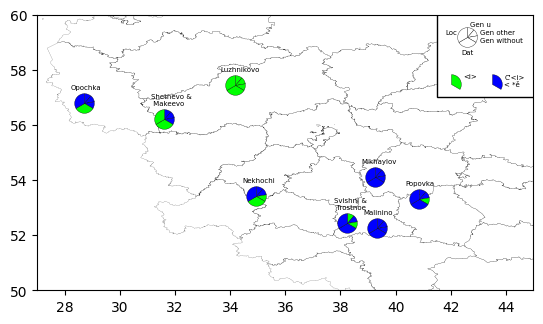

In [19]:
collection = PatchCollection(polygons, edgecolor='black', facecolor='none', linewidths=0.1)

fig, ax = plt.subplots()
ax.add_collection(collection)

# plt.scatter(*coords_corpora.T, c=codes, cmap='tab20', s=10)

size = 200
linewidth = 0.25
div_ = 1

for (corpus, coord), gen_u_rgb_, gen_other_rgb_, gen_without_rgb_, dat_rgb_, loc_rgb_ in zip(labels, gen_u_rgb, gen_other_rgb, gen_without_rgb, dat_rgb, loc_rgb):
    ax.scatter(*coord, marker=gen_u_path, s=size, color=gen_u_rgb_, edgecolor='black', linewidth=linewidth/div_)
    ax.scatter(*coord, marker=gen_other_path, s=size, color=gen_other_rgb_, edgecolor='black', linewidth=linewidth/div_)
    ax.scatter(*coord, marker=gen_without_path, s=size, color=gen_without_rgb_, edgecolor='black', linewidth=linewidth/div_)
    
    # ax.scatter(*coord, marker=gen_path, s=size, color='none', edgecolor='black', linewidth=linewidth)
    
    ax.scatter(*coord, marker=dat_path, s=size, color=dat_rgb_, edgecolor='black', linewidth=linewidth)
    ax.scatter(*coord, marker=loc_path, s=size, color=loc_rgb_, edgecolor='black', linewidth=linewidth)

    if " & " in corpus:
        ax.text(*coord - np.array((0.5, -0.5)), corpus.replace(" & ", " &\n "), fontsize=5)
    else:
        ax.text(*coord - np.array((0.5, -0.5)), corpus.replace(" & ", "\n"), fontsize=5)


rect = Rectangle((41.5, 57), 5, 20, linewidth=1, edgecolor="k", facecolor="w")
ax.add_patch(rect)

coord = np.array((42.6, 59.2))

ax.scatter(*coord, marker=gen_u_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.1, 0.4)), "Gen u", fontsize=5)

ax.scatter(*coord, marker=gen_other_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.45, 0.1)), "Gen other", fontsize=5)

ax.scatter(*coord, marker=gen_without_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.45, -0.2)), "Gen without", fontsize=5)

ax.scatter(*coord, marker=dat_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((-0.2, -0.65)), "Dat", fontsize=5)

ax.scatter(*coord, marker=loc_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((-0.8, 0.1)), "Loc", fontsize=5)

coord = np.array((42, 57.5))
color_anno_move = np.array((0.45, 0.2))
ax.scatter(*coord, marker=gen_path, s=size, color=[0, 1, 0], edgecolor='black', linewidth=linewidth)
ax.text(*coord + color_anno_move, "<i>", fontsize=5)

x_move = np.array((1.5, 0))

ax.scatter(*coord + x_move, marker=gen_path, s=size, color=[0, 0, 1], edgecolor='black', linewidth=linewidth)
ax.text(*coord + x_move + color_anno_move - np.array((0, 0.285)), "C'<i>\n< *ě", fontsize=5)

ax.autoscale()
ax.set_aspect('equal')

ax.set_xlim([27, 45])
ax.set_ylim([50, 60])
plt.savefig("map.png", bbox_inches='tight', dpi=300)

In [20]:
# with stress
gen_unpaired_e = [0, 1, 0, 0, 1, 0, 1, 0]
gen_unpaired_i = [0, 0, 0, 0, 0, 0, 0, 0]
gen_unpaired_Ci = abs(np.array(gen_unpaired_e) - 1)

gen_paired_e = [1, 0, 0, 0, 1, 0, 0, 0]
gen_paired_i = [0, 0, 0, 0, 0, 0, 0, 0]
gen_paired_Ci = abs(np.array(gen_paired_e) - 1)

dat_unpaired_i = [0, 0, 0, 0, 0, 0, 0, 0]
dat_unpaired_Ci = [0, 0, 0, 0, 0, 0, 1, 0]
dat_unpaired_e = abs(np.array(dat_unpaired_Ci) - 1)

dat_paired_i = [0, 0, 0, 0, 0, 0, 0, 0]
dat_paired_Ci = [0, 0, 1, 0, 1, 0, 0, 0]
dat_paired_e = abs(np.array(dat_paired_Ci) - 1)

loc_unpaired_i = [0, 0, 0, 0, 0, 0, 0, 0]
loc_unpaired_Ci = [0, 0, 1, 0, 0, 1, 0, 0]
loc_unpaired_e = abs(np.array(loc_unpaired_Ci) - 1)

loc_paired_i = [0, 0, 0, 0, 0, 0, 0, 0]
loc_paired_Ci = [1, 0, 1, 0, 0, 0, 0, 0]
loc_paired_e = abs(np.array(loc_paired_Ci) - 1)

In [21]:
gen_unpaired_rgb = np.stack((gen_unpaired_e, gen_unpaired_i, gen_unpaired_Ci)).T.astype(float)
gen_unpaired_none = np.array([1, 0, 0, 0, 0, 0, 0, 1])
gen_unpaired_rgb[gen_unpaired_none == 1] = 1

gen_paired_rgb = np.stack((gen_paired_e, gen_paired_i, gen_paired_Ci)).T.astype(float)
gen_paired_none = np.array([0, 0, 0, 1, 0, 1, 0, 0])
gen_paired_rgb[gen_paired_none == 1] = 1

dat_unpaired_rgb = np.stack((dat_unpaired_e, dat_unpaired_i, dat_unpaired_Ci)).T.astype(float)
dat_unpaired_none = np.array([1, 1, 1, 1, 1, 1, 0, 1])
dat_unpaired_rgb[dat_unpaired_none == 1] = 1

dat_paired_rgb = np.stack((dat_paired_e, dat_paired_i, dat_paired_Ci)).T.astype(float)
dat_paired_none = np.array([0, 1, 0, 1, 0, 1, 1, 1])
dat_paired_rgb[dat_paired_none == 1] = 1

loc_unpaired_rgb = np.stack((loc_unpaired_e, loc_unpaired_i, loc_unpaired_Ci)).T.astype(float)
loc_unpaired_none = np.array([0, 1, 0, 0, 0, 0, 1, 1])
loc_unpaired_rgb[loc_unpaired_none == 1] = 1

loc_paired_rgb = np.stack((loc_paired_e, loc_paired_i, loc_paired_Ci)).T.astype(float)
loc_paired_none = np.array([0, 1, 0, 1, 0, 0, 0, 1])
loc_paired_rgb[loc_paired_none == 1] = 1

In [22]:
gen_unpaired_path = create_sector_marker(90, 30)
gen_paired_path = create_sector_marker(30, -30)
dat_unpaired_path = create_sector_marker(-30, -90)
dat_paired_path = create_sector_marker(-90, -150)
loc_unpaired_path = create_sector_marker(-150, -210)
loc_paired_path = create_sector_marker(-210, -270)

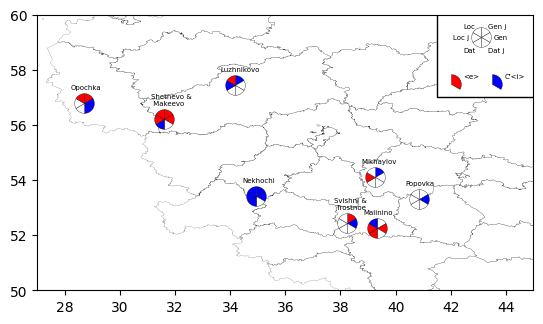

In [23]:
collection = PatchCollection(polygons, edgecolor='black', facecolor='none', linewidths=0.1)

fig, ax = plt.subplots()
ax.add_collection(collection)

# plt.scatter(*coords_corpora.T, c=codes, cmap='tab20', s=10)

size = 200
linewidth = 0.25
div_ = 1

for (corpus, coord), gen_unpaired_rgb_, gen_paired_rgb_, dat_unpaired_rgb_, dat_paired_rgb_, loc_unpaired_rgb_, loc_paired_rgb_ in \
zip(labels, gen_unpaired_rgb, gen_paired_rgb, dat_unpaired_rgb, dat_paired_rgb, loc_unpaired_rgb, loc_paired_rgb):
    ax.scatter(*coord, marker=gen_unpaired_path, s=size, color=gen_unpaired_rgb_, edgecolor='black', linewidth=linewidth)
    ax.scatter(*coord, marker=gen_paired_path, s=size, color=gen_paired_rgb_, edgecolor='black', linewidth=linewidth)
    ax.scatter(*coord, marker=dat_unpaired_path, s=size, color=dat_unpaired_rgb_, edgecolor='black', linewidth=linewidth)
    ax.scatter(*coord, marker=dat_paired_path, s=size, color=dat_paired_rgb_, edgecolor='black', linewidth=linewidth)
    ax.scatter(*coord, marker=loc_unpaired_path, s=size, color=loc_unpaired_rgb_, edgecolor='black', linewidth=linewidth)
    ax.scatter(*coord, marker=loc_paired_path, s=size, color=loc_paired_rgb_, edgecolor='black', linewidth=linewidth)

    if " & " in corpus:
        ax.text(*coord - np.array((0.5, -0.5)), corpus.replace(" & ", " &\n "), fontsize=5)
    else:
        ax.text(*coord - np.array((0.5, -0.5)), corpus.replace(" & ", "\n"), fontsize=5)


rect = Rectangle((41.5, 57), 5, 20, linewidth=1, edgecolor="k", facecolor="w")
ax.add_patch(rect)

coord = np.array((43.1, 59.2))

ax.scatter(*coord, marker=gen_unpaired_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.25, 0.3)), "Gen j", fontsize=5)

ax.scatter(*coord, marker=gen_paired_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.45, -0.1)), "Gen", fontsize=5)

ax.scatter(*coord, marker=dat_unpaired_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((0.25, -0.55)), "Dat j", fontsize=5)

ax.scatter(*coord, marker=dat_paired_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((-0.65, -0.55)), "Dat", fontsize=5)

ax.scatter(*coord, marker=loc_unpaired_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((-1, -0.1)), "Loc j", fontsize=5)

ax.scatter(*coord, marker=loc_paired_path, s=size, color="w", edgecolor='black', linewidth=linewidth)
ax.text(*coord + np.array((-0.65, 0.3)), "Loc", fontsize=5)

coord = np.array((42, 57.5))
color_anno_move = np.array((0.45, 0.2))
ax.scatter(*coord, marker=gen_path, s=size, color=[1, 0, 0], edgecolor='black', linewidth=linewidth)
ax.text(*coord + color_anno_move, "<e>", fontsize=5)

x_move = np.array((1.5, 0))

ax.scatter(*coord + x_move, marker=gen_path, s=size, color=[0, 0, 1], edgecolor='black', linewidth=linewidth)
ax.text(*coord + x_move + color_anno_move, "C'<i>", fontsize=5)

ax.autoscale()
ax.set_aspect('equal')

ax.set_xlim([27, 45])
ax.set_ylim([50, 60])
plt.savefig("map.png", bbox_inches='tight', dpi=300)

In [24]:
ws = wb['Малинино']
ws_data = [[cell.value for cell in row] for row in ws["A1":"Q707"]]

df = pd.DataFrame(ws_data[1:], columns=ws_data[0])

In [25]:
df['target'] = df['Не Лит.'].apply(lambda x: 1 if x == 'НЕ лит.' else 0)
df = df.drop(["Не Лит."], axis=1)

In [26]:
renames = {
    'есть: другой': 'other',
    'есть: у': 'u',
    'есть: по': 'po',
    'нет': 'no'
}

df["Предлог"] = df["Предлог"].apply(lambda s: renames[s])

df["Case_Prep"] = df["Case"] + "_" + df["Предлог"]
df = df.drop(["Case", "Предлог"], axis=1)

In [27]:
df_filtered = df[df['Основа'] == 'парн. твердая'].copy()

In [28]:
df_filtered = df_filtered[df_filtered["String id"] != "nxs1949"]
df_filtered = df_filtered[df_filtered["String id"] != "zzx1958"]
df_filtered = df_filtered[df_filtered["String id"] != "anu"]
df_filtered = df_filtered[df_filtered["String id"] != "mja1930"]

In [29]:
pd.Series.value_counts(df_filtered["String id"])

String id
mgd1932    205
ams1941    104
pas1930     93
agg1933     82
vns1918     33
nvd1968     10
vis1941      9
mxs1964      8
Name: count, dtype: int64

In [30]:
df_filtered = df_filtered.rename(columns={
    "Место обр.": "Place",
    "Способ обр.": "Manner",
    "Ударение": "Accent",
    "Тип сущ.": "Noun_type",
    "Род": "Noun_gender"
})

In [31]:
renames = {
    'переднеязычный': 'coronal',
    'заднеязычный': 'velar',
    'губной': 'labial'
}

df_filtered["Place"] = df_filtered["Place"].apply(lambda s: renames[s])

renames = {
    'носовой': 'nasal',
    'взрывной': 'plosive',
    'щелевой': 'fricative',
    'вибрант': 'trill',
    'боковой аппроксимант': 'lateral'
}

df_filtered["Manner"] = df_filtered["Manner"].apply(lambda s: renames[s])

renames = {
    'на основу': 'stem',
    'на окончание': 'ending'
}

df_filtered["Accent"] = df_filtered["Accent"].apply(lambda s: renames[s])

renames = {
    'Нарицательное': 'common',
    'Имя человека': 'anthroponym',
    'Топоним': 'toponym'
}

df_filtered["Noun_type"] = df_filtered["Noun_type"].apply(lambda s: renames[s])

renames = {
    'муж.': 'masc',
    'жен.': 'fem'
}

df_filtered["Noun_gender"] = df_filtered["Noun_gender"].apply(lambda s: renames[s])

In [32]:
labels = {
    "Place": ['velar', 'coronal', 'labial'], 
    "Manner": ['fricative', 'plosive', 'trill', 'lateral', 'nasal'], 
    "Accent": ['ending', 'stem'], 
    "Case_Prep": ['Loc_other', 'Gen_no', 'Gen_u', 'Gen_other', 'Dat_no', 'Dat_po', 'Dat_other'],
    "Noun_type": ['common', 'anthroponym', 'toponym'],
    "Noun_gender": ['fem', 'masc']
}

for col in ['Place', 'Manner', 'Accent', 'Case_Prep', 'Noun_type', 'Noun_gender']:
    df_filtered[col + "_"] = df_filtered[col].apply(lambda s: labels[col].index(s))

In [33]:
def func(string):
    if string == "Group Var":
        return string
    pattern = r"C\(([a-zA-Z_]*)_\)\[T\.([\d])\]"
    groups = re.match(pattern, string).groups()
    return labels[groups[0]][int(groups[1])]

In [34]:
formula = "target ~ C(Manner_) + C(Place_) + C(Accent_) + C(Case_Prep_) + C(Noun_type_) + C(Noun_gender_)"
y, X = dmatrices(formula, df_filtered, return_type='dataframe')

X_vif = X.drop('Intercept', axis=1, errors='ignore')
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["Label"] = vif_data["Variable"].apply(func)
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

                Variable        Label       VIF
0        C(Manner_)[T.1]      plosive  4.180611
1        C(Manner_)[T.2]        trill  1.764208
2        C(Manner_)[T.3]      lateral  1.637773
3        C(Manner_)[T.4]        nasal  2.314471
4         C(Place_)[T.1]      coronal  3.090892
5         C(Place_)[T.2]       labial  1.331308
6        C(Accent_)[T.1]         stem  4.002633
7     C(Case_Prep_)[T.1]       Gen_no  1.284148
8     C(Case_Prep_)[T.2]        Gen_u  1.457493
9     C(Case_Prep_)[T.3]    Gen_other  1.221754
10    C(Case_Prep_)[T.4]       Dat_no  1.298476
11    C(Case_Prep_)[T.5]       Dat_po  1.141964
12    C(Case_Prep_)[T.6]    Dat_other  1.183576
13    C(Noun_type_)[T.1]  anthroponym  1.838922
14    C(Noun_type_)[T.2]      toponym  1.283416
15  C(Noun_gender_)[T.1]         masc  1.200360


In [35]:
model_full = sm.MixedLM(y, X, groups=df_filtered['String id'])
result_full = model_full.fit(reml=False)
llf_full = result_full.llf

C:\Users\stoyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [36]:
model_reduced = sm.OLS(y, X)
result_reduced = model_reduced.fit()
llf_reduced = result_reduced.llf

In [37]:
lr_stat = 2 * (llf_full - llf_reduced)
p_value = stats.chi2.sf(lr_stat, 1)
print("LRT χ² =", lr_stat, "p-value =", p_value)

LRT χ² = 3.865509103073691 p-value = 0.04928823838846278


In [38]:
print(result_full.cov_re)

           Group Var
Group Var    0.00029


In [39]:
print(result_full.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    target  
No. Observations:    544        Method:                ML      
No. Groups:          8          Scale:                 0.0209  
Min. group size:     8          Log-Likelihood:        278.5198
Max. group size:     205        Converged:             Yes     
Mean group size:     68.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.153    0.032 -4.835 0.000 -0.215 -0.091
C(Manner_)[T.1]       0.076    0.027  2.765 0.006  0.022  0.129
C(Manner_)[T.2]       0.122    0.037  3.266 0.001  0.049  0.196
C(Manner_)[T.3]       0.212    0.044  4.795 0.000  0.126  0.299
C(Manner_)[T.4]       0.094    0.030  3.093 0.002  0.035  0.154
C(Place_)[T.1]        0.037    0.021  1.788 0.074 -0.

In [40]:
print(result_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     11.46
Date:                Tue, 27 May 2025   Prob (F-statistic):           1.10e-25
Time:                        19:52:07   Log-Likelihood:                 276.59
No. Observations:                 544   AIC:                            -519.2
Df Residuals:                     527   BIC:                            -446.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1459 

In [41]:
result = result_full

In [42]:
coefs = pd.DataFrame({
    'feature': result.params.index,
    'coef': result.params,
    'p_value': result.pvalues
}).sort_values('coef', ascending=True)

data = coefs[coefs.index != 'Intercept'].copy()
data['color'] = data['p_value'].apply(lambda p: 'lightgrey' if p > 0.05 else 'orange')
data['label'] = data['feature'].apply(func)

data = data[data["feature"] != "Group Var"]

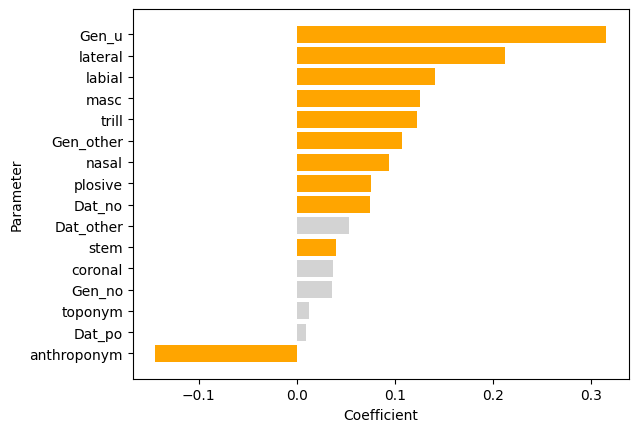

In [43]:
plt.barh(y=data['label'], width=data['coef'], color=data['color'])
plt.xlabel("Coefficient")
plt.ylabel("Parameter")
plt.savefig("plot.png", bbox_inches='tight', dpi=300)